## PREDICCIÓN PRECIO BITCOIN

In [1]:
from alpha_vantage.timeseries import TimeSeries
import json

# Acá se realiza el consumo de la API de AlphaVantage para descargar los datos desde el inicio hasta el dia de ayer
# sea cualquiera el dia de hoy. Esto se guarda en un archivo llamado "BTCUSD_daily.csv" La API permite realizar
# hasta 500 calls por día, con un máximo de 5 por minuto.

def save_dataset(symbol):
    api_key ='INSERTAR API KEY'
    
    ts = TimeSeries(key=api_key, output_format='pandas')
    data, meta_data = ts.get_daily(symbol, outputsize='full')
    data.to_csv('./{}_daily.csv'.format(symbol))
    


simbolo = 'BTCUSD'
save_dataset(simbolo)


nombre_archivo = '{}_daily.csv'.format(simbolo)

In [2]:
import pandas as pd
from sklearn import preprocessing
import numpy as np


#Los history_points son los puntos que se consideran para la predicción del día siguiente. 
history_points = 50

def csv_to_dataset(csv_path):
    datos = pd.read_csv(csv_path)

    # Se elimina el primer día
    datos  = datos.drop(0, axis=0)

    # Ordena de más antiguo a  más reciente
    datos = datos.sort_values('date')
    print(datos[50:])

    # Elimina la columna 'date'  
    datos = datos.drop('date', axis=1)

    # Normalización de los datos para mejorar la convergencia de la red neuronal
    normalizador = preprocessing.MinMaxScaler()
    datos_norm = normalizador.fit_transform(datos)

    # Usamos los últimos 50 ejemplos para predecir el siguiente valor de apertura (x)
    ohlcv_histories_normalised =np.array([datos_norm[i  : i + history_points].copy() for i in range(len(datos_norm) - history_points)])
    print("ohlcv_histories_normalised",'\n', ohlcv_histories_normalised[:10])
    
    # y
    next_day_open_values_normalised = np.array([datos_norm[:,0][i + history_points].copy() for i in range(len(datos_norm) - history_points)])
    next_day_open_values = np.array([datos.iloc[:,0][i + history_points].copy() for i in range(len(datos) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1)

    y_scaler = preprocessing.MinMaxScaler()
    y_scaler.fit_transform( next_day_open_values  )

    assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0]
    return ohlcv_histories_normalised, next_day_open_values_normalised, next_day_open_values, y_scaler

ohlcv_histories, next_day_open_values, unscaled_y, y_scaler = csv_to_dataset('BTCUSD_daily.csv')

test_split = 0.9 # Porcentaje de los datos usados para el train y test (90% train, 10% test)
n = int(ohlcv_histories.shape[0] * test_split)

# Separación de los datos en train y test de forma manual

ohlcv_train = ohlcv_histories[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]


            date     1. open     2. high      3. low    4. close  5. volume
4546  2011-10-30      3.6900      4.4000      3.6900      3.9500       88.0
4545  2011-10-31      3.8500      3.8500      3.2000      3.5000      116.0
4544  2011-11-01      3.2500      3.5500      3.2000      3.3000       68.0
4543  2011-11-02      3.3200      3.3300      3.3200      3.3300       38.0
4542  2011-11-05      3.2700      3.5500      3.2100      3.5500      117.0
...          ...         ...         ...         ...         ...        ...
5     2024-04-16  63457.2802  64394.9854  61649.3493  63822.2627    24526.0
4     2024-04-17  63821.6495  64532.0482  59664.1481  61286.3540    29809.0
3     2024-04-18  61278.5369  64200.9802  60827.5960  63513.1805    21347.0
2     2024-04-19  63512.1270  65500.0120  59592.8029  63845.2811    32047.0
1     2024-04-20  63845.5413  65458.2206  63132.8955  64969.8452     8048.0

[4546 rows x 6 columns]
ohlcv_histories_normalised 
 [[[1.18709349e-04 1.16920954e-04 1

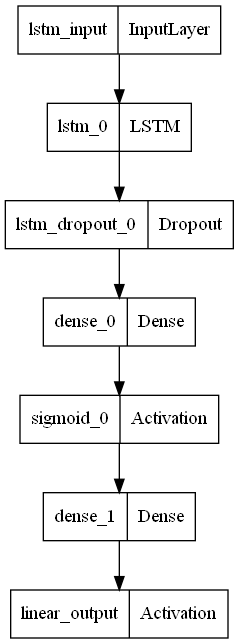

In [3]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
np.random.seed(4)


# Esta es la red neuronal para la obtención de las predicciones.
# Las diferentes capas de la red neuronal se pueden ver en el gráfico que se imprime debajo

lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)
model = Model(inputs=lstm_input, outputs=output)
adam = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)
model.compile(optimizer=adam, loss='mse')

In [5]:
model.fit(x=ohlcv_train, y=y_train, batch_size=32, epochs=30, shuffle=True, validation_split=0.1)
evaluation = model.evaluate(ohlcv_test, y_test)
print('Evaluation:' ,evaluation)

Epoch 1/3
116/116 [==============================] - 3s 29ms/step - loss: 3.5570e-04 - val_loss: 3.5672e-04
Epoch 2/3
116/116 [==============================] - 3s 28ms/step - loss: 3.0123e-04 - val_loss: 3.7190e-04
Epoch 3/3
15/15 [==============================] - 0s 15ms/step - loss: 3.0164e-04
Evaluation: 0.00030163899646140635


In [6]:

# Predicciones normalizadas
y_test_predicted = model.predict(ohlcv_test)

# En este paso se realiza la transformación inversa para obtener los valores reales de las predicciones
y_test_predicted = y_scaler.inverse_transform(y_test_predicted)

# Predicciones para todo el set de datos
y_predicted = model.predict(ohlcv_histories)

y_predicted = y_scaler.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)


143/143 [==============================] - 2s 13ms/step
11141851783.340834


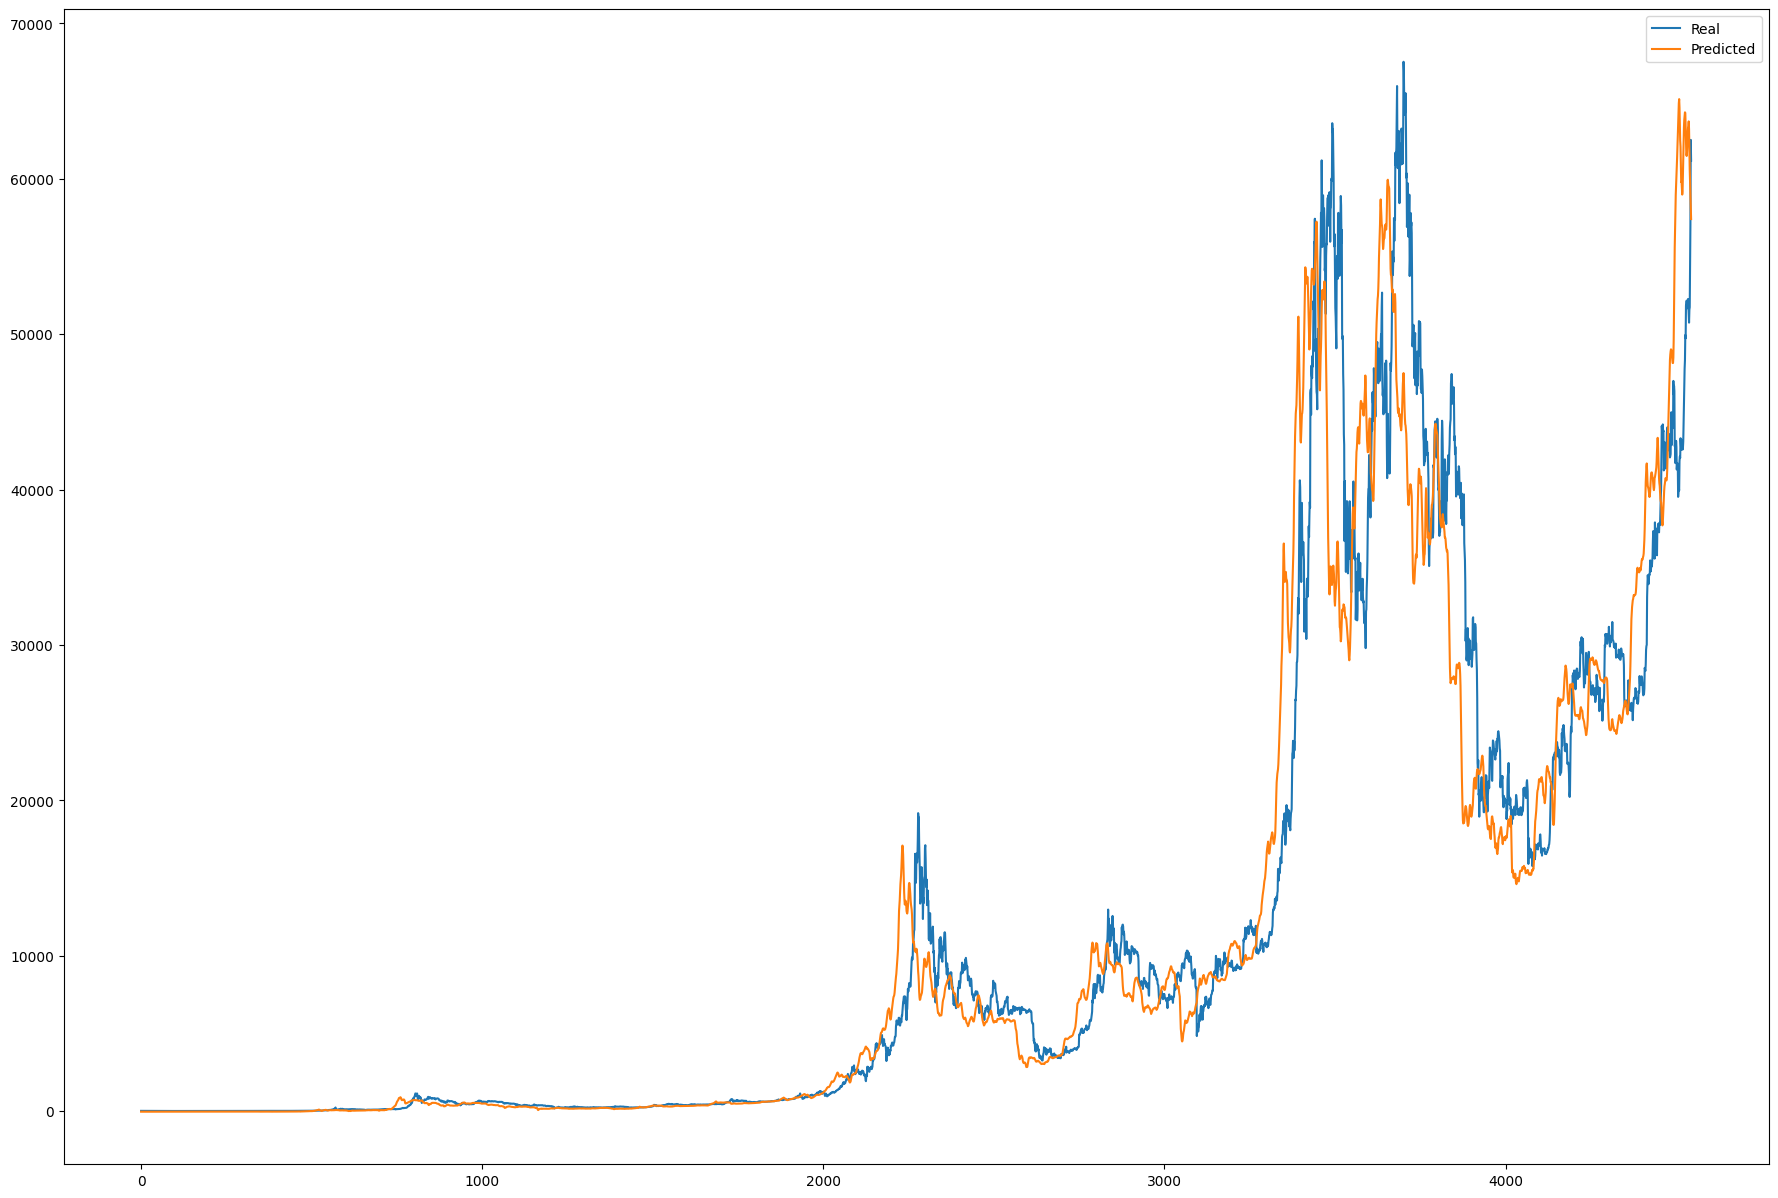

In [7]:
import matplotlib.pyplot as plt
plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

reversed_arr = unscaled_y[::-1]

real = plt.plot(reversed_arr[start:end], label='real')
pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

In [8]:
# Este es el valor de la última predicción que debería ser el que imprima la app (predicción del día siguiente)
y_predicted[-1]

array([57259.03], dtype=float32)

In [10]:
import pickle


# Guardar el modelo ajustado
with open('arima_model_btc.pkl', 'wb') as f:
    pickle.dump(y_predicted, f)